In [ ]:
from google.colab import drive 
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install tensorflow-gpu
!pip install python-bidi
!pip install arabic_reshaper

     |████████████████████████████████| 320.4MB 46kB/s 
  Created wheel for arabic-reshaper: filename=arabic_reshaper-2.1.0-cp36-none-any.whl size=16502 sha256=e3a82afdee8a246b49c9f093eb3fc29b19df7778f2bb8cd5900c436f920f6f2a
  Stored in directory: /root/.cache/pip/wheels/a9/e6/ec/2ba48138d4447d40442dd6ba3bf6b92d9c6afd74e9c720c6fe
Successfully built arabic-reshaper


In [ ]:
from __future__ import absolute_import, division, print_function

# Import TensorFlow >= 1.10 and enable eager execution
import tensorflow as tf

#tf.enable_eager_execution()

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from bidi.algorithm import get_display
import arabic_reshaper

import unicodedata
import re
import numpy as np
import os
import time
import math

print(tf.__version__)

2.3.0


In [ ]:
file_path = '/content/drive/My Drive/real.txt' 


In [ ]:
lines = open(file_path, encoding='UTF-8').read().strip().split('\n')
lines[200:800]

['jib mekla: /أحضر الطعام.',
 'jib 3ina: /أحضِر المُساعدة.',
 'najm no93od: /هل أستطيع أن أبقى؟ ',
 'hez hetha: /احمل هذا.',
 'tfa9ad hetha: /إفحص ذلك.',
 'tfa9ad heka: /إفحص هذا.',
 'ija maraokhra: /تعالَ مُجدداً.',
 'ija wa7dek: /تعالَ وحدك.',
 'ija wahdek: /تعالَ بمفردك.',
 'ija m3ana: /تعال معنا.',
 'haya odkhol: /هيا ادخل',
 'haya odkhol: /هيا ادخل',
 'ihja fisa3: /تعال بسرعة.',
 'ijeli: /تعال إلي',
 'jemla: /قطعاً',
 'matet7arakch: /لا تتحرك.',
 '3abiha: /املئها.',
 'lawej ala 5edma: /إبحث عن عمل',
 'tab3ou: /اتبعه.',
 'emchi lel khedma: /اذهب إلى العمل',
 '3ala khir /ليلة سعيدة.',
 'koun moumen: /كن مؤمنا.',
 'ma7leh: /إنه لطيف.',
 'howa mridh: /إنه مريض.',
 'howa thki: /هو ذكي.',
 'howa thki: /إنه ذكي.',
 'howa hne /ها هو هنا',
 'ahaya: /ها هي.',
 'ena tfol: /أنا ولد.',
 'ena fer7an: /أنا سعيد',
 'najem nagez: /يمكنني القفز.',
 'najem nagez: /أستطيع القفز.',
 'najem nagez:. /يمكنني أن أقفز.',
 'najem n3oum: /يمكنني السباحة.',
 'najem n3oum: /بإمكاني أن أسبح.',
 'chnekel hne: /س

In [ ]:
def unicode_to_ascii(s):
    '''
    Args:
        s : UniCode file
    Returns:
        ASCII file
    
    Converts the unicode file to ascii
    '''
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    '''
    Args:
        w : A single word
    Returns:
        w : Single normalize word 
    
    Convert Unicode to ASCII
    Creating a space between a word and the punctuation following it
    eg: "he is a boy." => "he is a boy ." 
    Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    
    Replacing everything with space except (a-z, A-Z, ا-ي ".", "?", "!", ",")
    
    Adding a start and an end token to the sentence
    
    '''
    w = unicode_to_ascii(w.lower().strip())
    
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    
    w = '<start> %s <end>'%w
    return w

In [ ]:
sent_pairs = []
try:
  for line in lines:
      sent_pair = []
      DT, AR = line.split("/")
      DT = preprocess_sentence(DT)
      sent_pair.append(DT)
      AR = preprocess_sentence(AR)
      sent_pair.append(AR)
      sent_pairs.append(sent_pair)
except ValueError:
    pass


In [ ]:
sent_pairs[400:800]

[['<start> 3andou kalb <end>', '<start> لديه كلب .  <end>'],
 ['<start> haw yekel <end>', '<start> انه ياكل .  <end>'],
 ['<start> howa khaleni nemchi <end>', '<start> هو تركني اذهب .  <end>'],
 ['<start> howa khalena nemchiw <end>', '<start> هو تركنا نذهب .  <end>'],
 ['<start> howa y7ebha <end>', '<start> انه يحبها .  <end>'],
 ['<start> tmanyek 3liya <end>', '<start> لقد سخر مني .  <end>'],
 ['<start> batal <end>', '<start> كان شجاعا .  <end>'],
 ['<start> chay yfaded <end>', '<start> كم هذا مزعج !  <end>'],
 ['<start> ena sini <end>', '<start> انا صيني <end>'],
 ['<start> haw fedar <end>', '<start> اني في المنزل .  <end>'],
 ['<start> n7eb na3ref <end>', '<start> اود ان اعرف .  <end>'],
 ['<start> manajamch ntkalm <end>', '<start> لا استطيع الكلام .  <end>'],
 ['<start> nchalah <end>', '<start> امل ذلك .  <end>'],
 ['<start> mayhemnich <end>', '<start> لا اهتم .  <end>'],
 ['<start> maya3ninich <end>', '<start> الامر لا يعنيني .  <end>'],
 ['<start> mana3rafch <end>', '<start> لا ا

In [ ]:
class LanguageIndex():
    def __init__(self, lang):
        self.lang = lang
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()

        self.create_index()

    def create_index(self):
        for phrase in self.lang:
            self.vocab.update(phrase.split(' '))

        self.vocab = sorted(self.vocab)

        self.word2idx['<pad>'] = 0
        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1

        for word, index in self.word2idx.items():
            self.idx2word[index] = word

In [ ]:

def max_length(tensor):
    return max(len(t) for t in tensor)
  

In [ ]:
def load_dataset(pairs, num_examples):
    # pairs => already created cleaned input, output pairs

    # index language using the class defined above    
    inp_lang = LanguageIndex(en for en, ma in pairs)
    targ_lang = LanguageIndex(ma for en, ma in pairs)
    
    # Vectorize the input and target languages
    
    # English sentences
    input_tensor = [[inp_lang.word2idx[s] for s in en.split(' ')] for en, ma in pairs]
    
    # Marathi sentences
    target_tensor = [[targ_lang.word2idx[s] for s in ma.split(' ')] for en, ma in pairs]
    
    # Calculate max_length of input and output tensor
    # Here, we'll set those to the longest sentence in the dataset
    max_length_inp, max_length_tar = max_length(input_tensor), max_length(target_tensor)
    
    # Padding the input and output tensor to the maximum length
    input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, 
                                                                 maxlen=max_length_inp,
                                                                 padding='post')
    
    target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, 
                                                                  maxlen=max_length_tar, 
                                                                  padding='post')
    
    return input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_tar

In [ ]:
input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_targ = load_dataset(sent_pairs, len(lines))


In [ ]:

# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.1, random_state = 101)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

(513, 513, 58, 58)

In [ ]:

BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
N_BATCH = BUFFER_SIZE//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word2idx)
vocab_tar_size = len(targ_lang.word2idx)

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 7]), TensorShape([64, 17]))

In [ ]:
def gru(units):
    
    '''
    Args: 
        units: number of units
    Return:
        GRU units
    
    If you have a GPU, we recommend using CuDNNGRU(provides a 3x speedup than GRU)
    the code automatically does that.
    '''
    return tf.keras.layers.GRU(units, 
                                return_sequences=True, 
                                return_state=True, 
                                recurrent_activation='sigmoid', 
                                recurrent_initializer='glorot_uniform')

In [ ]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [ ]:
class Decoder(tf.keras.Model):
    ''' Create the decoder, also needs to have access to the source information.
    
    This class create decoder which consists of decoder_cell (similar to encoder_cell), 
    a helper, and the previous encoder_state as inputs.
    
    Attributes:
        vocab_size: Size of vocabulary
        embedding_dim: Embedding vector length
        enc_units:  Number of GRUs units
        batch_sz: batch size ** minimize it for low RAM
    '''
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.dec_units)
        self.fc = tf.keras.layers.Dense(vocab_size)
        
        # used for attention
        self.W1 = tf.keras.layers.Dense(self.dec_units)
        self.W2 = tf.keras.layers.Dense(self.dec_units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        
        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying tanh(FC(EO) + FC(H)) to self.V
        score = self.V(tf.nn.tanh(self.W1(enc_output) + self.W2(hidden_with_time_axis)))
        
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * enc_output
        context_vector = tf.reduce_sum(context_vector, axis=1)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        # passing the concatenated vector to the GRU
        output, state = self.gru(x)
        
        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))
        
        # output shape == (batch_size * 1, vocab)
        x = self.fc(output)
            
        return x, state, attention_weights
        
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.dec_units))
    
    def saved_hidden_state(self):
        return self.gru.states

In [ ]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

In [ ]:

optimizer = tf.optimizers.Adam()
def loss_function(real, pred):
    mask = 1 - np.equal(real, 0)
    loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask
    return tf.reduce_mean(loss_)

In [ ]:
save_dir = '/content/drive/My Drive/Internship/model'
encoder_prefix = os.path.join(save_dir, "encoder_weights")
decoder_prefix = os.path.join(save_dir, "decoder_weights")

In [ ]:
EPOCHS = 5

for epoch in range(EPOCHS):
    start = time.time()
    
    hidden = encoder.initialize_hidden_state()
    total_loss = 0
    
    for (batch, (inp, targ)) in enumerate(dataset):
        loss = 0
        
        with tf.GradientTape() as tape:
            enc_output, enc_hidden = encoder(inp, hidden)
            
            dec_hidden = enc_hidden
            
            dec_input = tf.expand_dims([targ_lang.word2idx['<start>']] * BATCH_SIZE, 1)       
            
            # Teacher forcing - feeding the target as the next input
            for t in range(1, targ.shape[1]):
                # passing enc_output to the decoder
                predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
                
                loss += loss_function(targ[:, t], predictions)
                
                # using teacher forcing
                dec_input = tf.expand_dims(targ[:, t], 1)
        
        batch_loss = (loss / int(targ.shape[1]))
        
        total_loss += batch_loss
        
        variables = encoder.variables + decoder.variables
        
        gradients = tape.gradient(loss, variables)
        
        optimizer.apply_gradients(zip(gradients, variables))
        
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()))
            
    
    
        
        
        encoder.save_weights(encoder_prefix)
        decoder.save_weights(decoder_prefix)
        
        print('Saving weights at epoch {} with Loss {:.4f}'.format(epoch + 1, total_loss / N_BATCH))
        
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
   


Epoch 1 Batch 0 Loss 1.8738
Saving weights at epoch 1 with Loss 0.2342
Saving weights at epoch 1 with Loss 0.4456
Saving weights at epoch 1 with Loss 0.6579
Saving weights at epoch 1 with Loss 0.8587
Saving weights at epoch 1 with Loss 1.0397
Saving weights at epoch 1 with Loss 1.1870
Saving weights at epoch 1 with Loss 1.3572
Saving weights at epoch 1 with Loss 1.5094
Time taken for 1 epoch 11.827733755111694 sec

Epoch 2 Batch 0 Loss 1.1193
Saving weights at epoch 2 with Loss 0.1399
Saving weights at epoch 2 with Loss 0.2873
Saving weights at epoch 2 with Loss 0.4380
Saving weights at epoch 2 with Loss 0.5819
Saving weights at epoch 2 with Loss 0.7181
Saving weights at epoch 2 with Loss 0.8512
Saving weights at epoch 2 with Loss 0.9988
Saving weights at epoch 2 with Loss 1.1360
Time taken for 1 epoch 4.539032459259033 sec

Epoch 3 Batch 0 Loss 0.9976
Saving weights at epoch 3 with Loss 0.1247
Saving weights at epoch 3 with Loss 0.2516
Saving weights at epoch 3 with Loss 0.3847
Saving

In [ ]:
    def load_model(self, save_dir):
        encoder_prefix = os.path.join(save_dir, "encoder_weights")
        decoder_prefix = os.path.join(save_dir, "decoder_weights")

        self.encoder.load_weights(encoder_prefix)
        self.decoder.load_weights(decoder_prefix)

In [ ]:
def evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    
    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word2idx[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')
    inputs = tf.convert_to_tensor(inputs)
    
    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word2idx['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        
        # storing the attention weigths to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.idx2word[predicted_id] + ' '

        if targ_lang.idx2word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [ ]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    
    heatmap = ax.matshow(attention, cmap='rainbow')

    for y in range(attention.shape[0]):
        for x in range(attention.shape[1]):
            ax.text(x , y, '%.4f' % attention[y, x],
                     horizontalalignment='center',
                     verticalalignment='center', color='black')

    fig.colorbar(heatmap)

    fontdict = {'fontsize': 14}
    
    ax.set_xticklabels([''] + sentence, fontdict=fontdict)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    plt.show()

In [ ]:
def translate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    result, sentence, attention_plot = evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)
        
    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, get_display(arabic_reshaper.reshape(sentence)).split(' '), result.split(' '))

Input: <start> kamel <end>
Predicted translation: .  <end> 


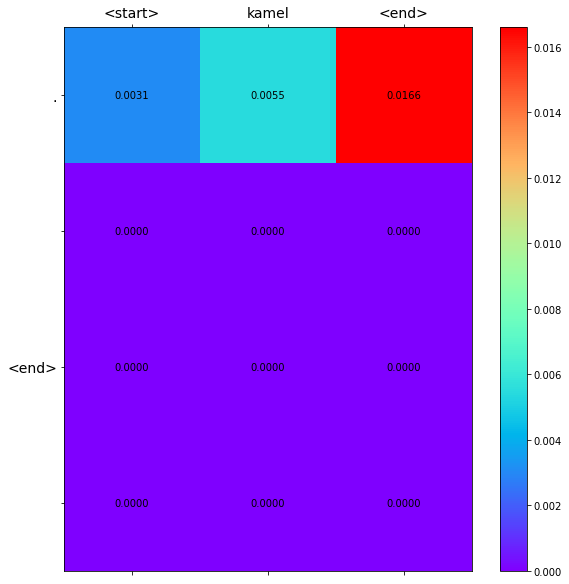

In [ ]:
translate(u'kamel', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)

Input: <start> ejri <end>
Predicted translation: انا .  <end> 


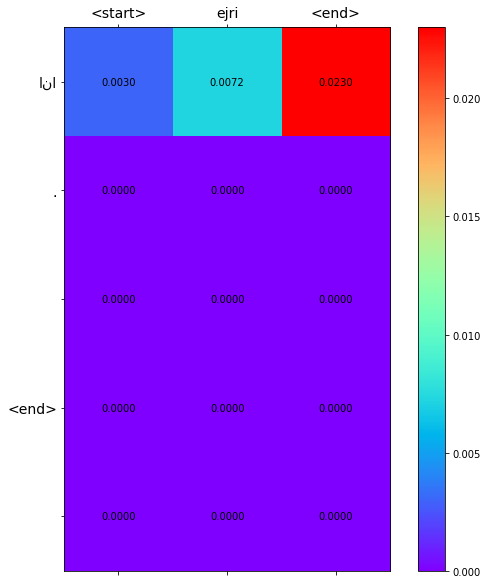

In [ ]:
translate(u'ejri', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)

Input: <start> n7eb <end>
Predicted translation: انا .  <end> 


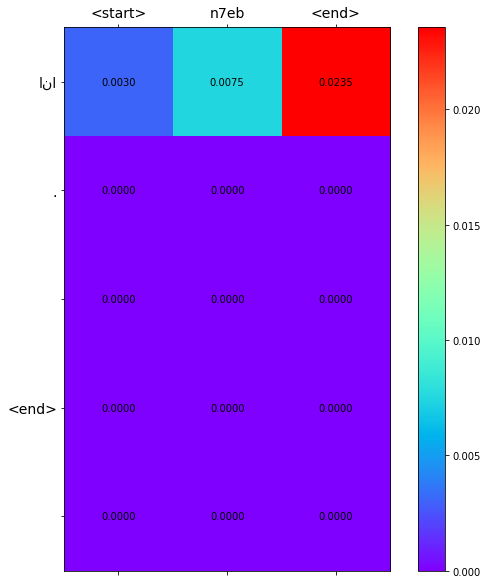

In [ ]:
translate(u'n7eb', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)

Input: <start> a3mal <end>
Predicted translation: انا .  <end> 


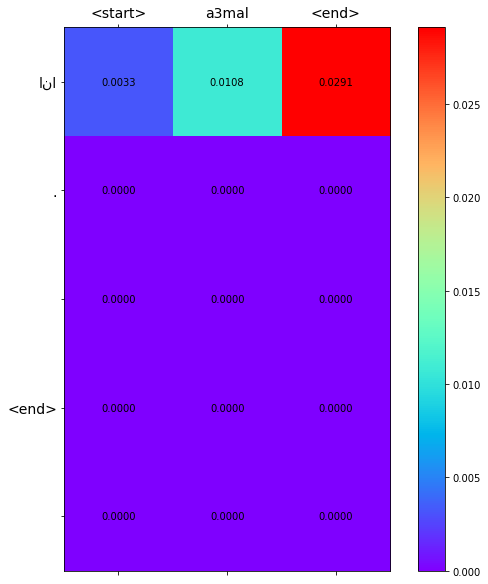

In [ ]:
translate(u'a3mal', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)